

---


  

> # **군AI교육지원사업**
**자연어 처리**



---

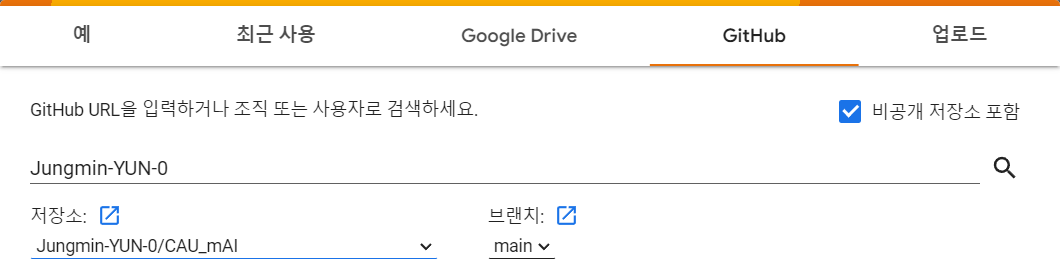

##WEEK 6
=========
### 1. Assignment (week3) 

### 2. RNN
>2-1. CharRNN
>
>2-2. Assignment (week6)
>
>2-3. Sentiment Analysis

## 1. Assignment(week3)

**[XOR 게이트]**

입력값 두 개가 서로 다른 값을 갖고 있을때에만 출력값이 1이 되고, 입력값 두 개가 서로 같은 값을 가지면 출력값이 0이 되는 게이트

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device) 
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

In [ ]:
"""
자유롭게 코드 구현
"""

In [ ]:
linear = nn.Linear(2, 1, bias=True)
sigmoid = nn.Sigmoid()
model = nn.Sequential(linear, sigmoid).to(device)

In [ ]:
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

In [ ]:
for epoch in range(2000):
    optimizer.zero_grad()
    # forward 연산
    output = model(X)

    # 비용 함수
    loss = criterion(output, Y)
    loss.backward()
    optimizer.step()

    # 10의 배수에 해당되는 에포크마다 비용을 출력
    if epoch % 100 == 0:
        print(epoch, loss.item())

In [ ]:
# 예측값
predicted = (output>0.5).float()
accuracy = (predicted==Y).float().mean()
print('모델의 출력값(Hypothesis): ', output.detach().cpu().numpy())
print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
print('실제값(Y): ', Y.cpu().numpy())
print('정확도(Accuracy): ', accuracy.item())

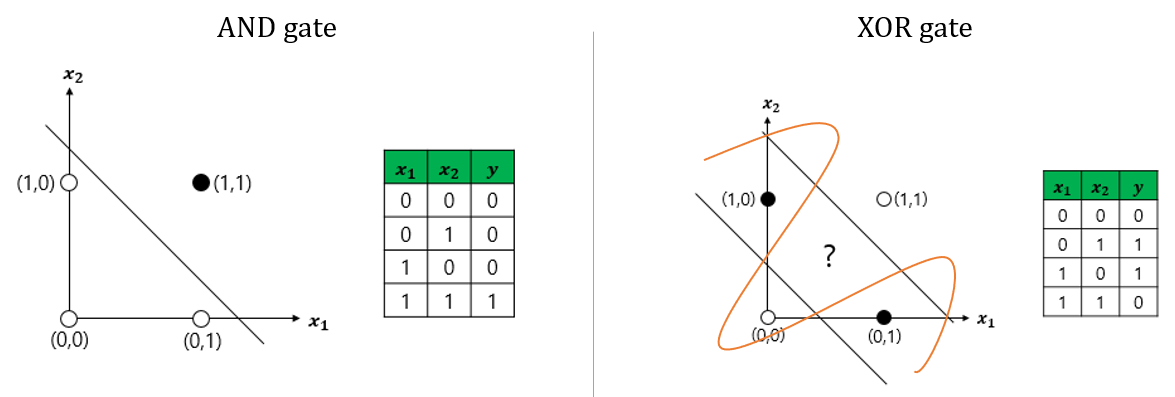

In [ ]:
model = nn.Sequential(
          nn.Linear(2, 10, bias=True), # input_layer = 2, hidden_layer1 = 10
          nn.Sigmoid(),
          nn.Linear(10, 10, bias=True), # hidden_layer1 = 10, hidden_layer2 = 10
          nn.Sigmoid(),
          nn.Linear(10, 10, bias=True), # hidden_layer2 = 10, hidden_layer3 = 10
          nn.Sigmoid(),
          nn.Linear(10, 1, bias=True), # hidden_layer3 = 10, output_layer = 1
          nn.Sigmoid()
          ).to(device)

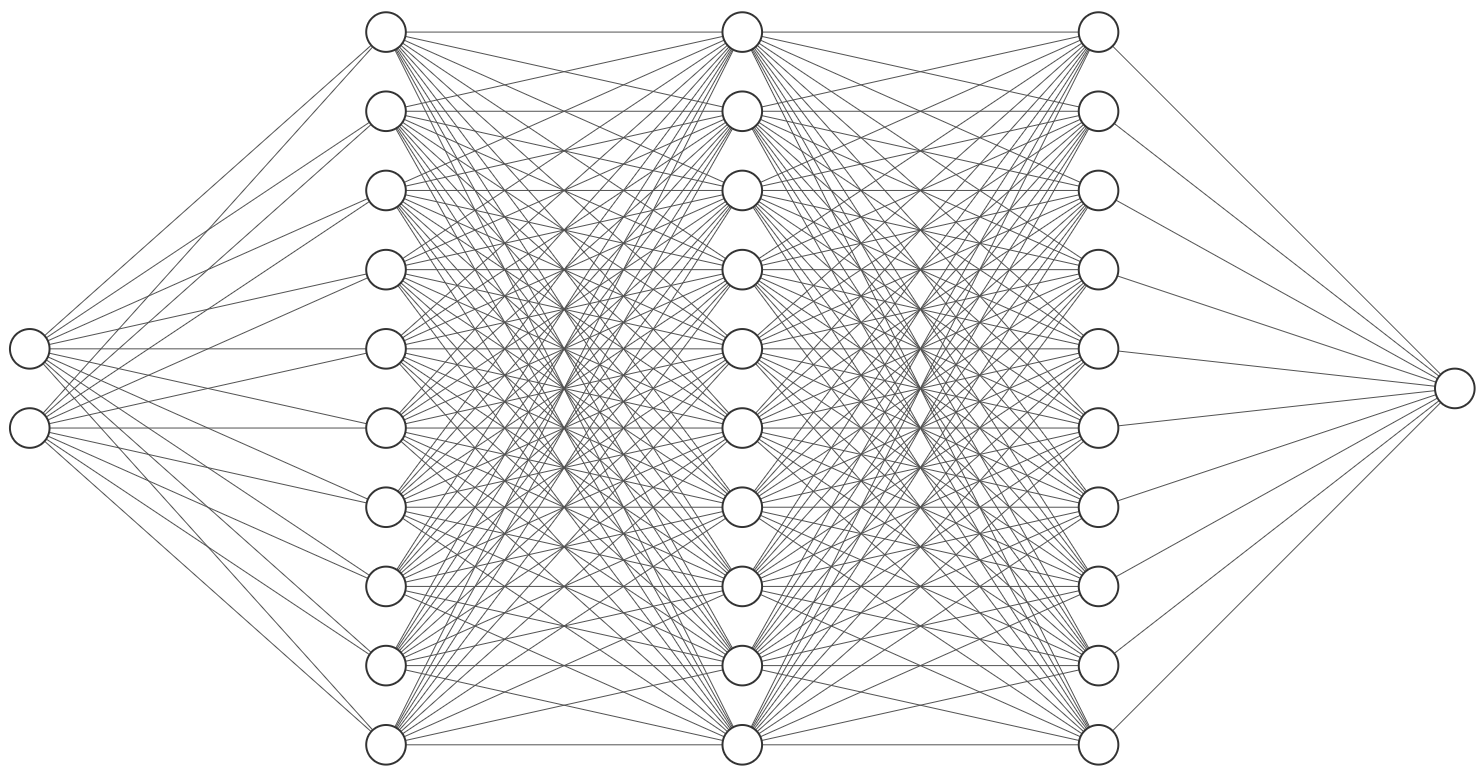

In [ ]:
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1)  # modified learning rate from 0.1 to 1

for epoch in range(10000):
    optimizer.zero_grad()
    # forward 연산
    hypothesis = model(X)

    # 비용 함수
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    # 100의 배수에 해당되는 에포크마다 비용을 출력
    if epoch % 1000 == 0:
        print(epoch, cost.item())

In [ ]:
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('모델의 출력값(Hypothesis): ', hypothesis.detach().cpu().numpy())
    print('모델의 예측값(Predicted): ', predicted.detach().cpu().numpy())
    print('실제값(Y): ', Y.cpu().numpy())
    print('정확도(Accuracy): ', accuracy.item())

## SkipGram

In [ ]:
## Skip-Gram 모델 정의

embedding_dim = 128
embedding_max_norm = 1   # Embedding Layer의 weight가 너무 커지지 않도록 제한

class SkipGram(nn.Module):
    def __init__(self, embedding_dim, vocab_size: int, context_size=4):
        super(SkipGram, self).__init__()
        ##############################################################
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)       # [48, 128] 48:vocabsize, 128:embedidng_size
        self.layer = nn.Linear(embedding_dim, vocab_size*context_size)  # [128, 192(=48*4)]

        self.context_size = context_size
        self.vocab_size = vocab_size        
        ##############################################################
    def forward(self, input):                                           # [1]
        ########################################################                   
        x = self.embeddings(input)                                      # [1, 128] (=[1x48]x[48x128])
        x = self.layer(x)                                               # [1, 192] ##(1,48)*4
        
        output = x.view(self.context_size, self.vocab_size)        # [4, 48] 

        output = F.softmax(output, dim=-1)
        
        ########################################################
        return output

<img src = "https://upload.wikimedia.org/wikipedia/commons/9/95/Skip-gram.png" height = 420 width = 360>

In [ ]:
## using pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
class SkipGram(nn.Module) :
    def __init__(self, vocab_size, dim) :
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, dim)  # [48, 128] 
        self.linear = nn.Linear(dim, vocab_size)  # [128, 48] 
    
    def forward(self, x) :
        embeddings = self.embedding(x)
        output = self.linear(embeddings)
        return output

In [ ]:
example_sentence = "In the case of CBOW, one word is eliminated, and the word is predicted from surrounding words. Therefore, it takes multiple input vectors as inputs to the model and creates one output vector. In contrast, Skip-Gram learns by removing all words except one word and predicting the surrounding words in the context through one word.  So, it takes a vector as input and produces multiple output vectors. CBOW and Skip-Gram are different." 
example_data = example_sentence.split('. ')
example_data

In [ ]:
# Tokenization (just split)
tokenized_sentence = []
for sentence in example_data:
  tokenized_sentence.append(sentence.split())

# Make Vocabulary
vocab = set([token for sentence in tokenized_sentence for token in sentence])    # 중복제거
#-----------------------------------------------------------------------
## Make Dictionary _ word2index{word: index}, index2word{index: word}

word2index = {word:index for index, word in enumerate(vocab)}
index2word = {index:word for index, word in enumerate(vocab)}
#-----------------------------------------------------------------------

In [ ]:
class SkipGramDataset(Dataset) :
    def __init__(self, train_tokenized, vocab, window_size = 2) :
        self.x = []
        self.y = []
        
        for tokens in train_tokenized :
            token_ids = [vocab[token] for token in tokens]
            for i, id in enumerate(token_ids) :
                if i-window_size >= 0 and i+window_size < len(token_ids) :
                    self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1]) #y:context
                    self.x += [id] * 2 * window_size #x:center(* context개수)
        self.x = torch.LongTensor(self.x)
        self.y = torch.LongTensor(self.y)
    
    def __len__(self) :
        return self.x.shape[0]
        
    def __getitem__(self, idx) :
        return self.x[idx], self.y[idx]

In [ ]:
skipgram_set = SkipGramDataset(tokenized_sentence, word2index)

batch_size = 4
loader = DataLoader(skipgram_set, batch_size = batch_size)

In [ ]:
# ('case', ['In', 'the', 'of', 'CBOW,']
## ('case', 'In'),
## ('case', 'the'),
## ('case', 'of'),
## ('case', 'CBOW,')

In [ ]:
model = SkipGram(vocab_size = len(word2index), dim = 256).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
learning_rate = 5e-4
num_epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.train()
model = model

for e in range(1, num_epochs + 1) :
    print(f"Epoch: {e}")
    for batch in loader:
        x, y = batch  #x:input(center), y:target(context)
        x, y = x.to(device), y.to(device)
        output = model(x)
        
        optimizer.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()
    
    print(f"Train loss per epoch: {loss.item()}")
print('Finished')

## 2. RNN

### 2.1 CharRNN

**[CharRNN]**

Character-level RNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

1. Data Preprocessing

In [ ]:
# apple

input_str = 'appl'    # input
label_str = 'pple'    # output

char_vocab = sorted(list(set(input_str+label_str)))
vocab_size = len(char_vocab)

print(f'vocab: {char_vocab}')
print(f'size of vocab: {vocab_size}')

In [ ]:
input_size = vocab_size
hidden_size = 4
output_size = 4
learning_rate = 0.1

In [ ]:
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)

In [ ]:
index_to_char={}
for key, value in char_to_index.items():
    index_to_char[value] = key
print(index_to_char)

In [ ]:
x_data = [[char_to_index[c] for c in input_str]]
y_data = [[char_to_index[c] for c in label_str]]
print(x_data)
print(y_data)

In [ ]:
x_one_hot = [np.eye(vocab_size)[x] for x in x_data]
print(x_one_hot)

In [ ]:
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

In [ ]:
print('훈련 데이터의 크기 : {}'.format(X.shape))
print('레이블의 크기 : {}'.format(Y.shape))

2. Model

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [ ]:
net = Net(input_size, hidden_size, output_size)

In [ ]:
outputs = net(X)
print(outputs.shape)

3. Train

In [ ]:
optimizer = optim.Adam(net.parameters(), learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for i in range(10):
    optimizer.zero_grad()
    outputs = net(X)
    loss = criterion(outputs.view(-1, input_size), Y.view(-1))
    loss.backward() 
    optimizer.step()

    result = outputs.data.numpy().argmax(axis=2)
    result_str = ''.join([index_to_char[c] for c in np.squeeze(result)])
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

### 2-2. Assignment(week6)

**[before]** charcater-level RNN

appl → pple

**[Assigment]** word-level RNN

Repeat is the best medicine for → is the best medicine for memory

- Hint: one-hot vector 대신 embedding 사용


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
sentence = "Repeat is the best medicine for memory".split()
vocab = list(set(sentence))
print(vocab)

['best', 'medicine', 'the', 'for', 'Repeat', 'memory', 'is']


In [3]:
word2index = {tkn: i for i, tkn in enumerate(vocab, 1)}
word2index['<unk>']=0

index2word = {value: key for key, value in word2index.items()}

print(index2word)
print(word2index)

{1: 'best', 2: 'medicine', 3: 'the', 4: 'for', 5: 'Repeat', 6: 'memory', 7: 'is', 0: '<unk>'}
{'best': 1, 'medicine': 2, 'the': 3, 'for': 4, 'Repeat': 5, 'memory': 6, 'is': 7, '<unk>': 0}


In [4]:
def build_data(sentence, word2index):
    encoded = [word2index[token] for token in sentence] 
    input_seq, label_seq = encoded[:-1], encoded[1:] 
    input_seq = torch.LongTensor(input_seq).unsqueeze(0) 
    label_seq = torch.LongTensor(label_seq).unsqueeze(0) 
    
    return input_seq, label_seq

X, Y = build_data(sentence, word2index)

print(X)
print(Y)

tensor([[5, 7, 3, 1, 2, 4]])
tensor([[7, 3, 1, 2, 4, 6]])


In [5]:
class Net(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, batch_first=True):
        super(Net, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=input_size)
        self.rnn_layer = nn.RNN(input_size, hidden_size, batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # print(x.size())
        output = self.embedding_layer(x)
        # print(output.size())
        output, hidden = self.rnn_layer(output)
        # print(output.size())
        output = self.linear(output)
        # print(output.size())
        output = output.view(-1, output.size(2))
        # print(output.size())
        return output

In [6]:
vocab_size = len(word2index)
input_size = 5
hidden_size = 20

model = Net(vocab_size, input_size, hidden_size, batch_first=True)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters())

In [7]:
decode = lambda y: [index2word.get(x) for x in y]

print(decode)

for step in range(200):
    optimizer.zero_grad()
    output = model(X)
    loss = loss_function(output, Y.view(-1))
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print("[{:02d}/200] {:.4f} ".format(step + 1, loss))
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ".join(["Repeat"] + decode(pred)))
        print()

<function <lambda> at 0x0000026720C6E1F0>
[01/200] 2.0824 
Repeat for the is is best the

[11/200] 1.9417 
Repeat for the is for for the

[21/200] 1.8068 
Repeat for the best medicine for memory

[31/200] 1.6662 
Repeat for the best medicine for memory

[41/200] 1.5140 
Repeat for the best medicine for memory

[51/200] 1.3516 
Repeat for the best medicine for memory

[61/200] 1.1860 
Repeat is the best medicine for memory

[71/200] 1.0248 
Repeat is the best medicine for memory

[81/200] 0.8747 
Repeat is the best medicine for memory

[91/200] 0.7401 
Repeat is the best medicine for memory

[101/200] 0.6230 
Repeat is the best medicine for memory

[111/200] 0.5238 
Repeat is the best medicine for memory

[121/200] 0.4415 
Repeat is the best medicine for memory

[131/200] 0.3741 
Repeat is the best medicine for memory

[141/200] 0.3194 
Repeat is the best medicine for memory

[151/200] 0.2751 
Repeat is the best medicine for memory

[161/200] 0.2391 
Repeat is the best medicine for memo

### 2-3. Sentiment Analysis

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchtext.legacy as torchtext
from torchtext.legacy import data, datasets
import random

In [ ]:
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

1. Data Preprocessing

torchtext

In [ ]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

In [ ]:
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

In [ ]:
print(vars(trainset[0]))

vocab

In [ ]:
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

In [ ]:
vocab_size = len(TEXT.vocab)
n_classes = 2
print('단어 집합의 크기 : {}'.format(vocab_size))
print('클래스의 개수 : {}'.format(n_classes))

In [ ]:
print(TEXT.vocab.stoi)

dataloader

In [ ]:
trainset, valset = trainset.split(split_ratio=0.8)

In [ ]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)

2. Model

In [ ]:
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))  # 첫번째 hidden state를 0으로 초기화
        x, _ = self.gru(x, h_0)  #[batch_size, sequence_length, hidden_dim]

        h_t = x[:,-1,:]  #[batch_size, hidden_sim]
        # 즉, 전체 hidden state에 대한 정보가 포함되어 있어서, 이때 마지막 time-step의 hidden state만 가져옴

        logit = self.out(h_t)   #[batch_size, output_dim(=num_class)]
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

3. Train

In [ ]:
model = GRU(1, 256, vocab_size, 128, n_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss().to(DEVICE)

In [ ]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # -1
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

def evaluate(model, val_iter):
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [ ]:
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))

In [ ]:
test_loss, test_acc = evaluate(model, test_iter)
print('test_loss: %5.2f | test_acc: %5.2f' % (test_loss, test_acc))